1. Extract Data from Kafka
First, extract the data from Kafka using a consumer. Libraries like kafka-python, confluent-kafka, or frameworks like Spark Streaming (with PySpark) can help you achieve this.

For example, using kafka-python:

In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost confluent-kafka orjson



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\dayzd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from confluent_kafka import Consumer, KafkaError
import json
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

consumer = Consumer({
    'bootstrap.servers': 'localhost:9095',
    'group.id': 'my-group',
    'auto.offset.reset': 'earliest'
})

consumer.subscribe(['elastiflow-flow-codex-1.0'])

data = []
message_count = 0  # Initialize the message counter

# Define a function to process each message
def process_message(msg):
    netflow_data = json.loads(msg.value().decode('utf-8'))
    
    # Get the DNS host
    dns_host = netflow_data.get("flow.server.host.name")
    
    # If the DNS host is a local IP (e.g., starts with "192.168"), replace it with a blank
    if dns_host and dns_host.startswith("192.168"):
        dns_host = "unknown"

    # Return the processed data
    return {
        "src_mac": netflow_data.get("flow.in.src.mac.addr"),
        "dst_mac": netflow_data.get("flow.in.dst.mac.addr"),
        "bytes": netflow_data.get("flow.bytes"),
        "packets": netflow_data.get("flow.packets"),
        "direction": netflow_data.get("flow.direction.name"),
        "protocol": netflow_data.get("l4.proto.name"),
        "client_port": netflow_data.get("flow.client.l4.port.id"),
        "server_port": netflow_data.get("flow.server.l4.port.id"),
        "client_as_label": netflow_data.get("flow.client.as.label"),
        "server_as_label": netflow_data.get("flow.server.as.label"),
        "client_as_org": netflow_data.get("flow.client.as.org"),
        "server_as_org": netflow_data.get("flow.server.as.org"),
        "community_id": netflow_data.get("flow.community.id"),
        "conversation_id": netflow_data.get("flow.conversation.id"),
        "dns_host": dns_host,  # Filtered or replaced value
        "start_offset": netflow_data.get("flow.start.time_offset"),
        "end_offset": netflow_data.get("flow.end.time_offset"),
    }

with ThreadPoolExecutor(max_workers=10) as executor:
    while True:
        msgs = consumer.consume(num_messages=500, timeout=0.1)  # Fetch up to 500 messages at once
        futures = [executor.submit(process_message, msg) for msg in msgs if msg is not None and not msg.error()]

        # Gather results as they complete
        for future in futures:
            result = future.result()
            if result:
                data.append(result)
                message_count += 1
                print(f"Message count: {message_count}")  # Print the current message count

        if len(data) >= 10000:  # Limit to 500 records for testing
            break

consumer.close()



Message count: 1
Message count: 2
Message count: 3
Message count: 4
Message count: 5
Message count: 6
Message count: 7
Message count: 8
Message count: 9
Message count: 10
Message count: 11
Message count: 12
Message count: 13
Message count: 14
Message count: 15
Message count: 16
Message count: 17
Message count: 18
Message count: 19
Message count: 20
Message count: 21
Message count: 22
Message count: 23
Message count: 24
Message count: 25
Message count: 26
Message count: 27
Message count: 28
Message count: 29
Message count: 30
Message count: 31
Message count: 32
Message count: 33
Message count: 34
Message count: 35
Message count: 36
Message count: 37
Message count: 38
Message count: 39
Message count: 40
Message count: 41
Message count: 42
Message count: 43
Message count: 44
Message count: 45
Message count: 46
Message count: 47
Message count: 48
Message count: 49
Message count: 50
Message count: 51
Message count: 52
Message count: 53
Message count: 54
Message count: 55
Message count: 56
M

# Convert to DataFrame # 

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Convert to DataFrame
df = pd.DataFrame(data)

# Handle missing values for fields that are already in the data
df['bytes'] = df['bytes'].fillna(0)
df['packets'] = df['packets'].fillna(0)
df['client_port'] = df['client_port'].fillna(0)
df['server_port'] = df['server_port'].fillna(0)
df['start_offset'] = df['start_offset'].fillna(0)
df['end_offset'] = df['end_offset'].fillna(0)

# Fill missing categorical values with 'unknown'
df['direction'] = df['direction'].fillna('unknown')
df['protocol'] = df['protocol'].fillna('unknown')
df['client_as_label'] = df['client_as_label'].fillna('unknown')
df['server_as_label'] = df['server_as_label'].fillna('unknown')
df['client_as_org'] = df['client_as_org'].fillna('unknown')
df['server_as_org'] = df['server_as_org'].fillna('unknown')
df['dns_host'] = df['dns_host'].fillna('unknown')

# Feature Engineering: Calculate byte-to-packet ratio
df['byte_packet_ratio'] = df['bytes'] / df['packets'].replace(0, 1)  # Avoid division by zero

# Define the list of features after they have been created
numerical_features = ['bytes', 'packets', 'client_port', 'server_port', 'byte_packet_ratio', 'start_offset', 'end_offset']
categorical_features = ['direction', 'protocol', 'client_as_label', 'server_as_label', 'client_as_org', 'server_as_org', 'dns_host']

# Preprocessing: Scaling and Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply transformations
df_preprocessed = pd.DataFrame(preprocessor.fit_transform(df))

# Now df_preprocessed contains the ready-to-use features for model training

In [18]:
# Display basic statistics
df_preprocessed.describe()

# Check for any missing or infinite values after preprocessing
print("Missing values:\n", df_preprocessed.isnull().sum())
print("Infinite values:\n", df_preprocessed.isin([float('inf'), float('-inf')]).sum())


Missing values:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
dtype: int64
Infinite values:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
dtype: int64


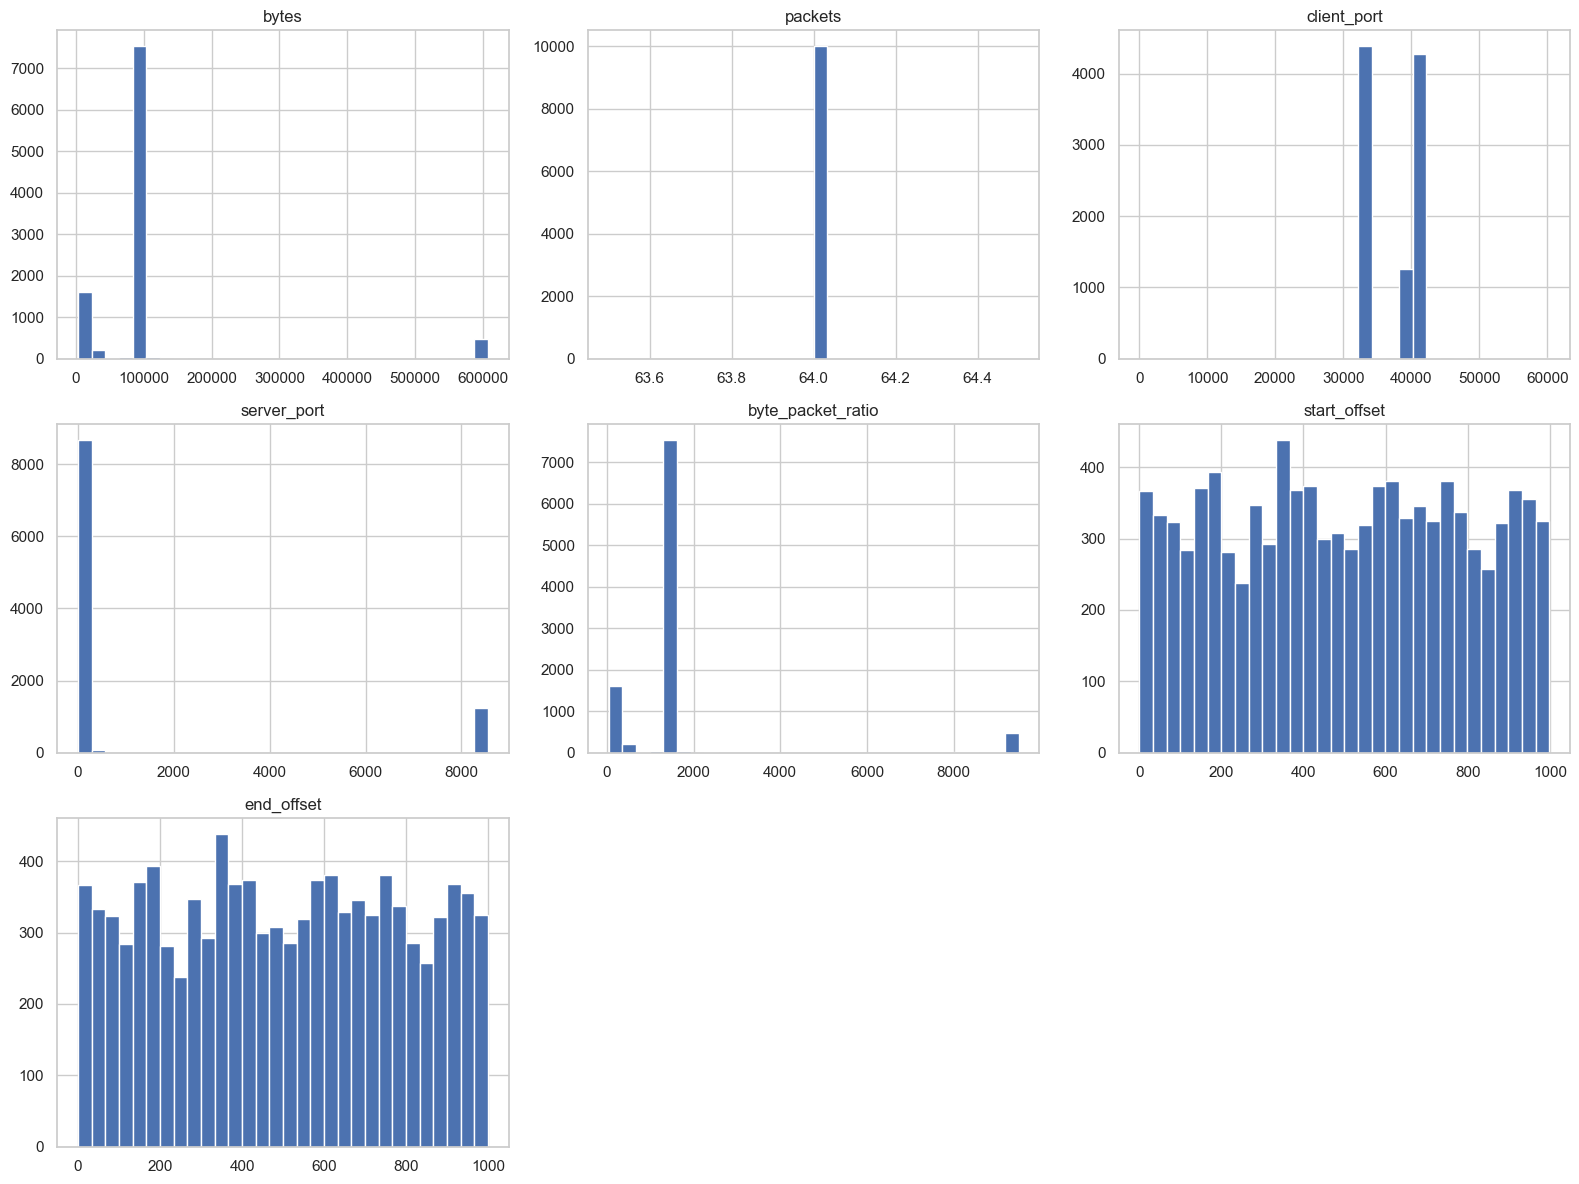

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set(style="whitegrid")

# Define the updated numerical features
numerical_features = ['bytes', 'packets', 'client_port', 'server_port', 'byte_packet_ratio', 'start_offset', 'end_offset']
df_numerical = df[numerical_features]

# Plot histograms for each numerical feature
df_numerical.hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()


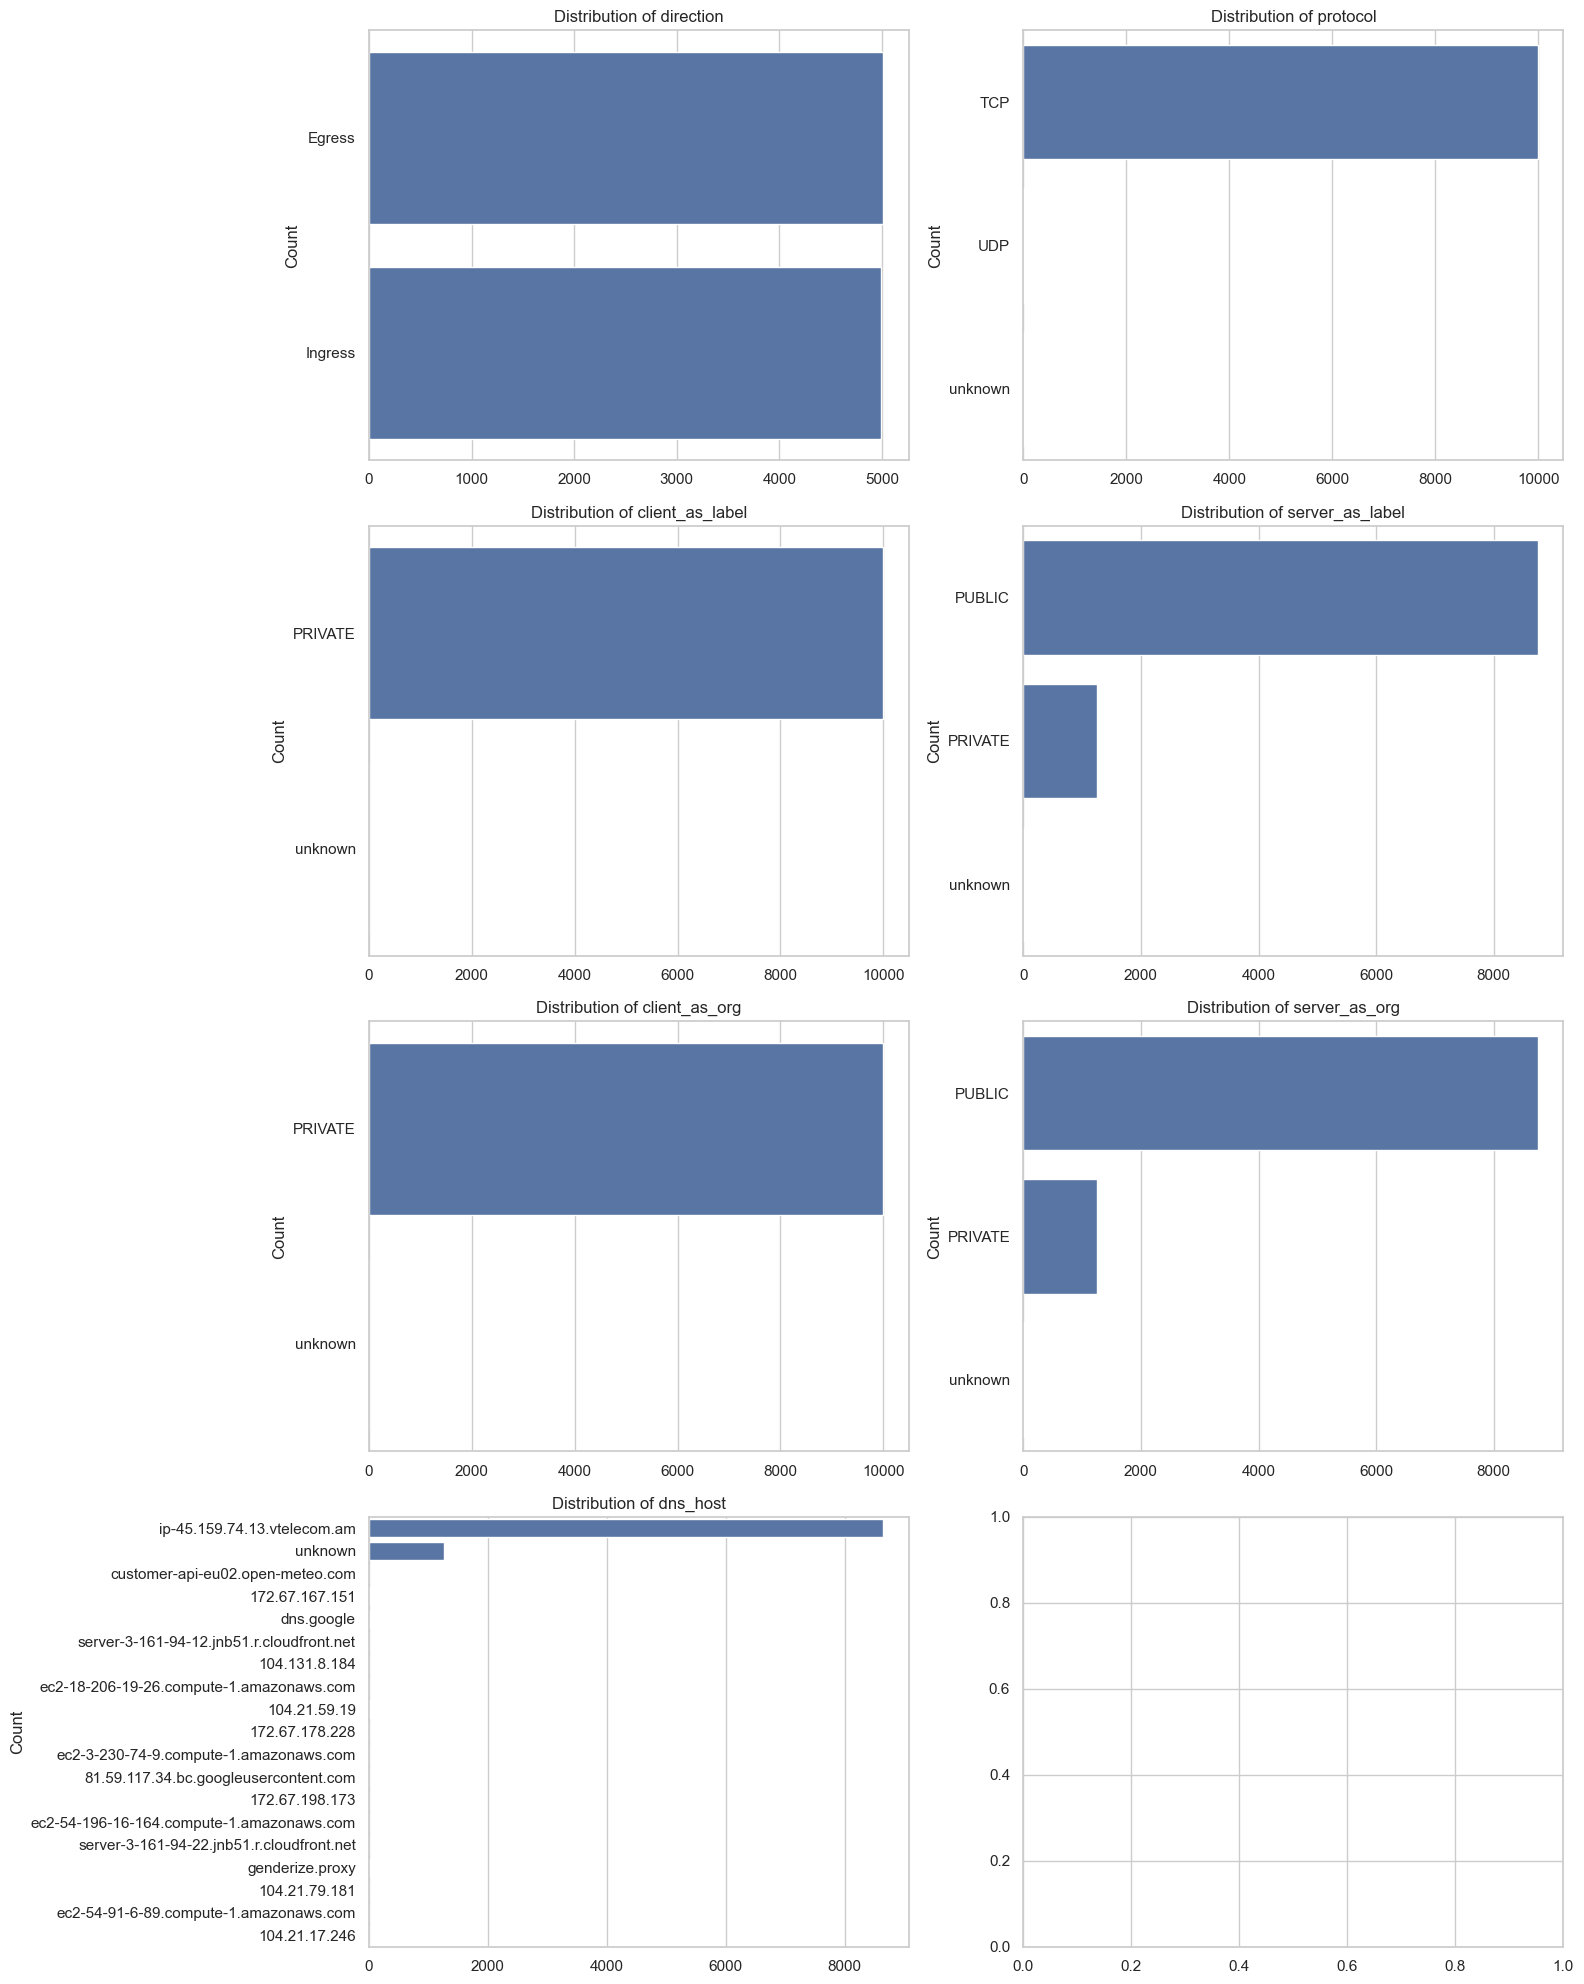

In [7]:
# 2. Plot Bar Charts for Categorical Features
categorical_features = ['direction', 'protocol', 'client_as_label', 'server_as_label', 'client_as_org', 'server_as_org', 'dns_host']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()



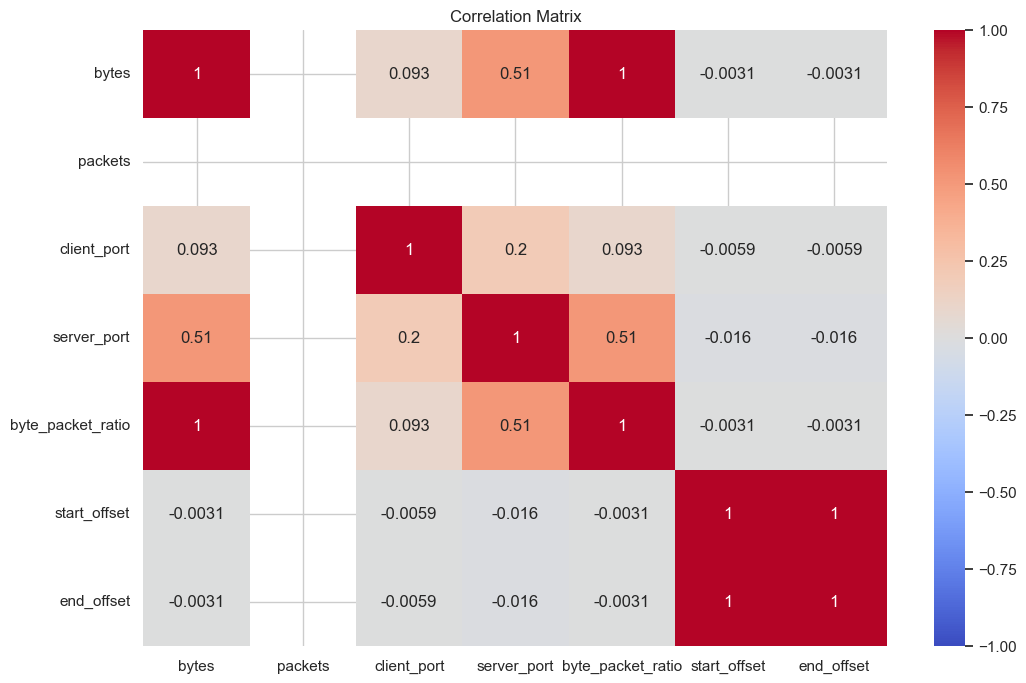

In [8]:
# 3. Correlation Analysis for Numerical Features
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()




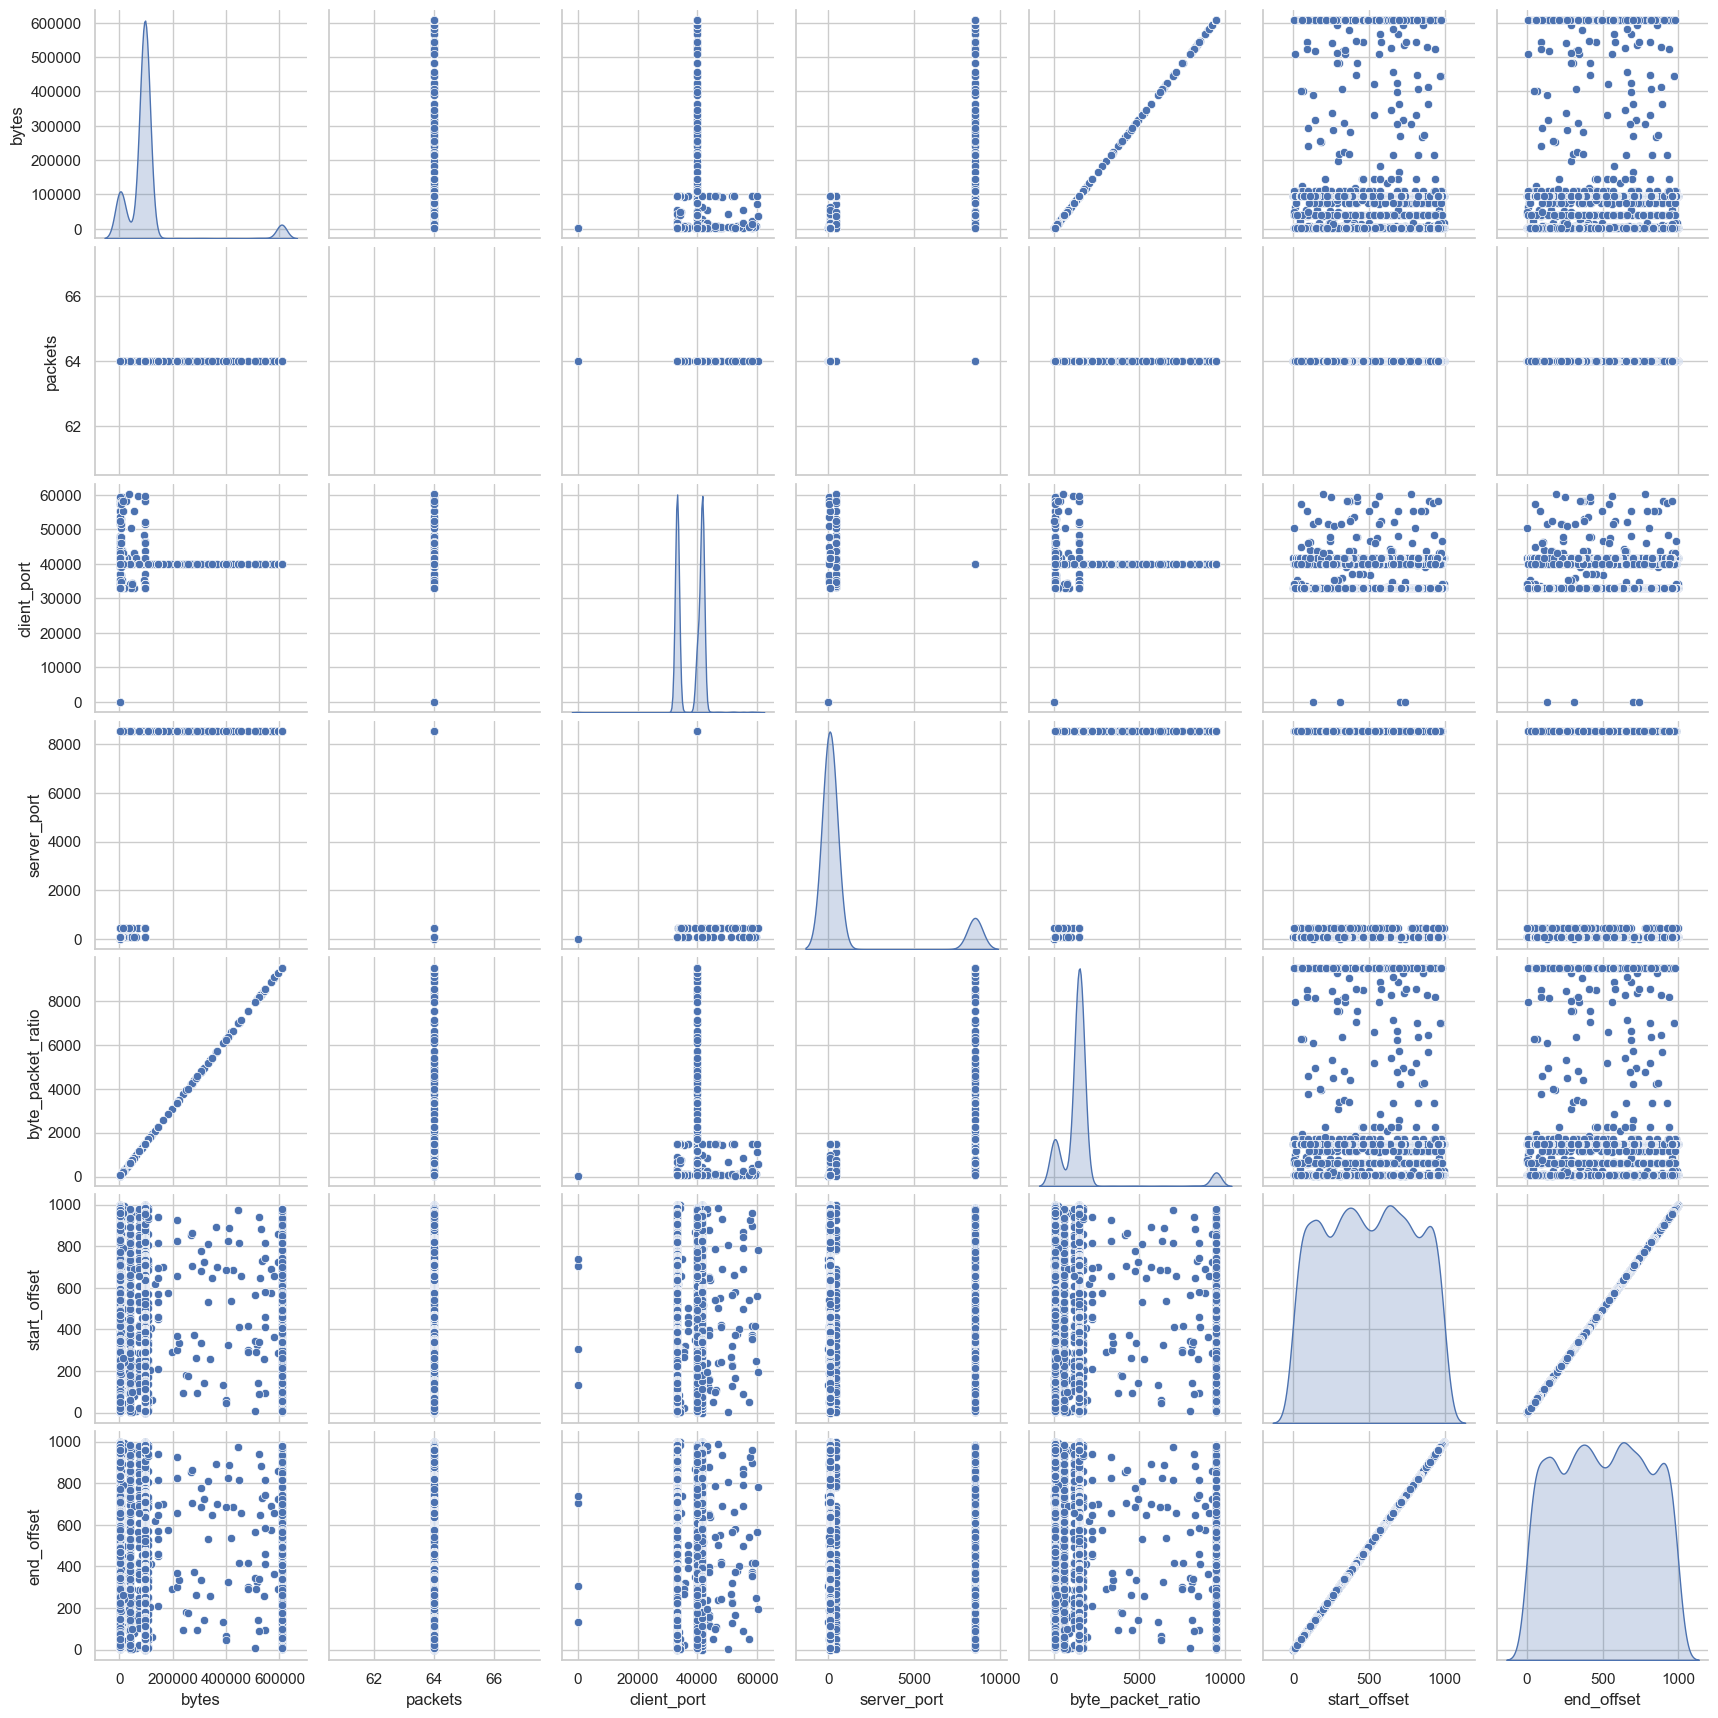

In [9]:
# 4. Pairplot for Numerical Feature Relationships (Optional, can be heavy if data is large)
sns.pairplot(df_numerical, diag_kind='kde')
plt.show()



In [14]:
# Create a label column based on the target MAC address
df['label2'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:02' or row['dst_mac'] == '00:00:00:00:00:02' else 0, axis=1)


In [15]:
print(df['label2'].value_counts())


label2
0    5627
1    4377
Name: count, dtype: int64


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1718
           1       1.00      1.00      1.00      1284

    accuracy                           1.00      3002
   macro avg       1.00      1.00      1.00      3002
weighted avg       1.00      1.00      1.00      3002



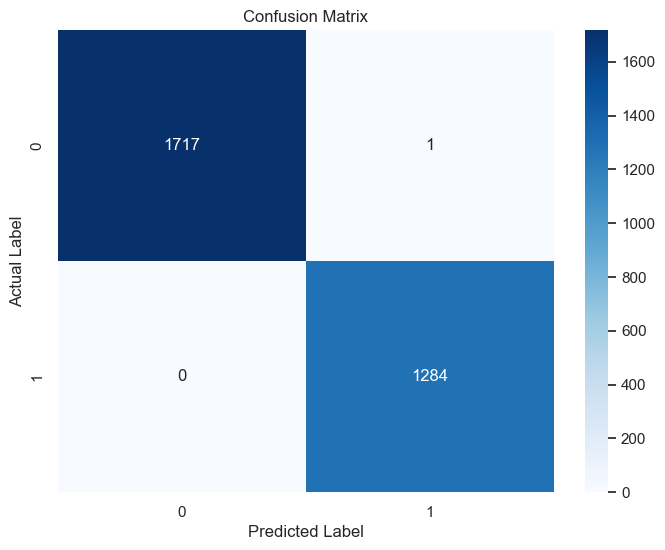

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define X (features) and y (label)
X = df_preprocessed
y = df['label2']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


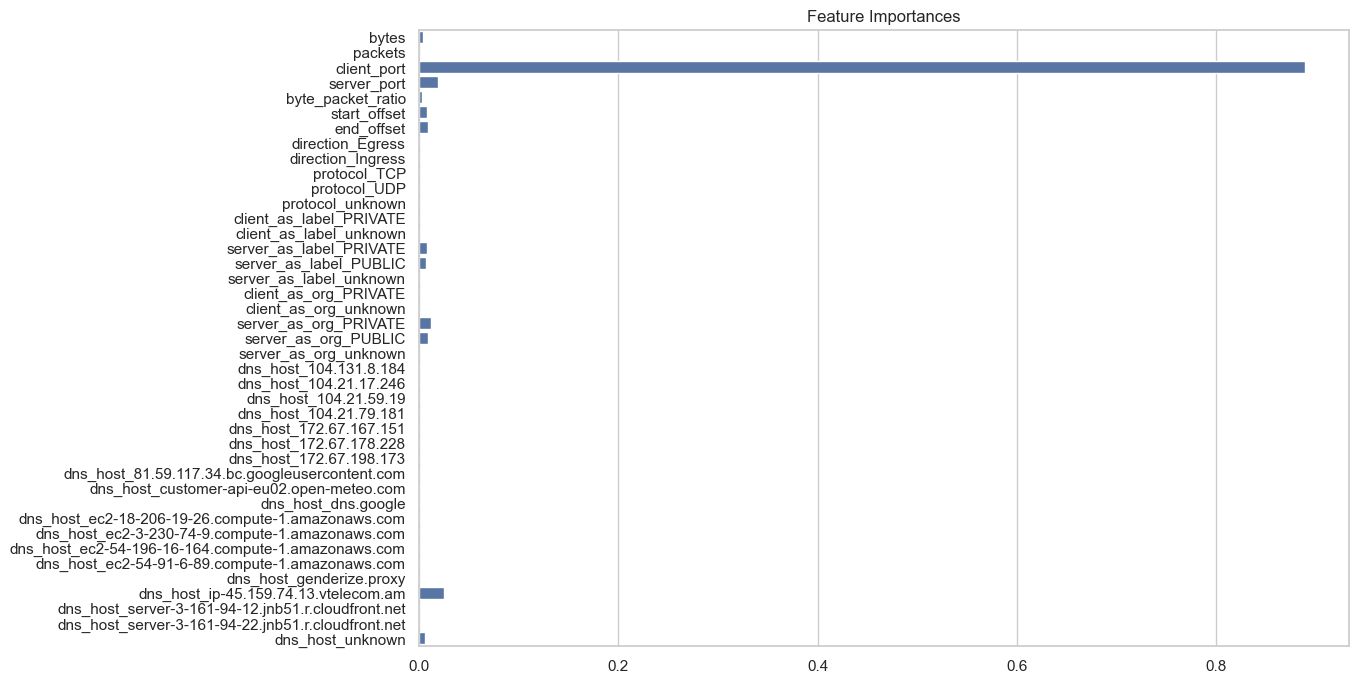

In [17]:
importances = model.feature_importances_
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.show()
